<a href="https://colab.research.google.com/github/ParisDBRavo/UTKFACE/blob/main/UTKFACE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de edades.
En este trabajo se utilizará la arquitectura ResNet como guía para hacer una regresión para predecir los datos del conjunto UTKFace. Se sustituirán los bloques de tipo ResNet por bloques CoNext.

## 1. Preparación

### 1.1 Librerias

In [ ]:
# biblioteca para inspeccionar arquitecturas
!pip install torch-summary
# https://github.com/TylerYep/torchinfo
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# sistema de archivos
import os
# funciones aleatorias
import random

from tqdm.auto import trange
from tqdm.auto import tqdm
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
from torchvision import transforms
from torchvision.ops import Permute
import torchvision.models as tvm
#redes
from torch.utils.data import DataLoader, random_split
# inspección de arquitectura
from torchsummary import summary
import matplotlib.pyplot as plt
# imágenes
from skimage import io
from skimage.transform import resize
from PIL import Image
from itertools import islice as take
import pandas as pd
from itertools import islice as take

### 1.2 Auxiliares

Me basé en la libreta vista en clase para descargar este conjunto de UTKFaces. 

In [ ]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/faces'
filename = 'UTKFace.tar.gz'
data_dir = '../data/faces/UTKFace'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8

# tamaño del conjunto de entrenamiento (porcentaje)
TRN_SIZE = 0.8
NUM_WORKERS = 4 # hilos

# media y varianza de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
  """Displays examples in a grid."""
  fig, ax = plt.subplots(rows, cols, figsize=figsize)
  i = 0
  for r in range(rows):
      for c in range(cols):
          ax[r, c].imshow(xs[i], cmap='gray')
          ax[r, c].set_title(titles[i])
          ax[r, c].set_xticklabels([])
          ax[r, c].set_yticklabels([])
          i += 1
  fig.tight_layout()
  plt.show()

def display_batch(x, titles, rows, cols, figsize=(12, 6)):
  """Despliega un lote en una cuadrícula."""
  # denormalizamos
  for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
      x[:, c] = x[:, c] * std + mean 
  x *= 255
  # rotamos canales
  x = x.permute(0, 2, 3, 1)
  # convertimos a entero
  x = (x.numpy()).astype(np.uint8)
  # desplegamos lote
  display_grid(x, titles, rows, cols, figsize)

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def display_losses(losses):
  train_loss, test_loss = zip(*losses)
  plt.plot(train_loss,label='Entrenamiento')
  plt.plot(test_loss,label='Prueba')
  plt.xlabel('Época')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.grid()
  plt.show()

def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x

# reproducibilidad
set_seed()

## 2. Datos

Aquí vamos a descargat UTKFace

In [ ]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

--2022-11-14 22:06:35--  https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.188.130.162
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.188.130.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106634631 (102M) [application/x-gzip]
Saving to: ‘../data/faces/UTKFace.tar.gz’

../data/faces/UTKFa 100%[===================>] 101.69M  7.47MB/s    in 11s     

2022-11-14 22:06:47 (9.30 MB/s) - ‘../data/faces/UTKFace.tar.gz’ saved [106634631/106634631]



Vemos como los archivos son todos .jpg y el nombre de cada uno de ellos. 

In [ ]:
! ls {data_dir} | head -5


100_0_0_20170112213500903.jpg.chip.jpg
100_0_0_20170112215240346.jpg.chip.jpg
10_0_0_20161220222308131.jpg.chip.jpg
10_0_0_20170103200329407.jpg.chip.jpg
10_0_0_20170103200522151.jpg.chip.jpg


Tengo los nombres de los archivos de prueba y de test para usarlos después.

In [ ]:
print(os.listdir(data_dir))
images_names= os.listdir(data_dir)
print(len(images_names))

['16_1_4_20170103234142187.jpg.chip.jpg', '17_0_3_20170117152534037.jpg.chip.jpg', '26_1_2_20170116180828579.jpg.chip.jpg', '27_1_1_20170103182202481.jpg.chip.jpg', '33_0_3_20170119164240414.jpg.chip.jpg', '32_1_0_20170116222855361.jpg.chip.jpg', '19_0_2_20170104020121132.jpg.chip.jpg', '23_1_0_20170117144945297.jpg.chip.jpg', '45_0_1_20170113141830522.jpg.chip.jpg', '23_1_2_20170116173215428.jpg.chip.jpg', '29_0_3_20170119195344995.jpg.chip.jpg', '41_0_0_20170117154651236.jpg.chip.jpg', '36_1_1_20170116163956549.jpg.chip.jpg', '78_0_2_20170112222034500.jpg.chip.jpg', '10_0_0_20170110225227587.jpg.chip.jpg', '35_0_2_20170116191142333.jpg.chip.jpg', '34_0_3_20170119200717205.jpg.chip.jpg', '1_1_4_20170103212116187.jpg.chip.jpg', '26_0_1_20170116210257827.jpg.chip.jpg', '59_0_0_20170111205324096.jpg.chip.jpg', '26_1_1_20170116221012056.jpg.chip.jpg', '24_0_4_20170103234945243.jpg.chip.jpg', '60_0_0_20170111171747558.jpg.chip.jpg', '28_1_0_20170105162552899.jpg.chip.jpg', '64_1_0_20170110

In [ ]:
random.shuffle(images_names)
#print(images_names)
trn_names= [images_names[i::int(len(images_names))] for i in range(int(len(images_names)*0.8))]
tst_names= [images_names[i::int(len(images_names))] for i in range(int(len(images_names)*0.8), int(len(images_names)))]
print(len(trn_names))
print(len(tst_names))
#print(trn_names)
trn_names = [item for items in trn_names for item in items]
tst_names = [item for items in tst_names for item in items]
#print(trn_names)
#print(tst_names)

18966
4742


Ahora se mostrará una visualización de los datos. Dejaré las modificaciones que realicé al código visto en clase. Lo que hace es adjuntar cada path de la imagen con su respectiva etiqueta.

In [ ]:
from ast import Name
class UTKFaceDS:

    def __init__(self, root, trn_names, test_names, tsfm, flag):
          
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # leemos el dataframe y filtramos columna healthy
        #df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        #df = df['healthy']
        
        # direcorios superiores
        #base_dir = os.path.join(root, 'trn')
        #classes = sorted(os.listdir(base_dir))
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        # por cada clase
        images = trn_names if flag == True else test_names
        for name in images:
            # directorio de la clase
            #class_dir = os.path.join(base_dir, clazz)
            # nombres de los archivos en el directorio de la clase
            #names = sorted(os.listdir(class_dir))
            # guardamos los rutas y las etiquetas
            #for name in names:
            #print(str(name))
            self.labels.append(name.split('_')[0])
            self.paths.append(f'{root}/{name}')

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

### 2.1 Exploración y creación de los conjuntos

Como lo menciona el ejercicio se crea una una reflexión horizontal para aumentar los datos.

In [ ]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    #transforms.CenterCrop(240),
    # redimensionamos a 64x64
    #transforms.Resize(IMG_SIZE),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
tst_tsfm = transforms.Compose([
    # convertimos a torch.Tensor
    transforms.ToTensor(),
    # Normalizamos
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [ ]:
trn_ds = UTKFaceDS(data_dir, trn_names, tst_names, tsfm,True)
tst_ds = UTKFaceDS(data_dir, trn_names, tst_names, tst_tsfm,False)



x shape=torch.Size([32, 3, 200, 200]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


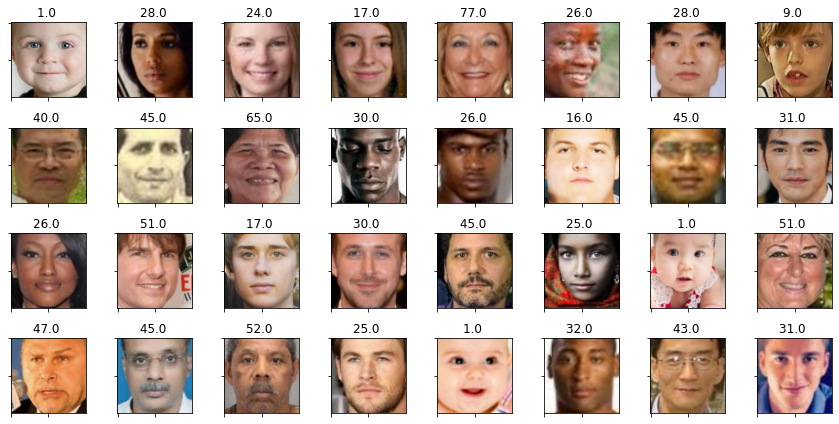

In [ ]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} '  for l in y]
display_batch(x, titles, ROWS, COLS)

x shape=torch.Size([32, 3, 200, 200]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


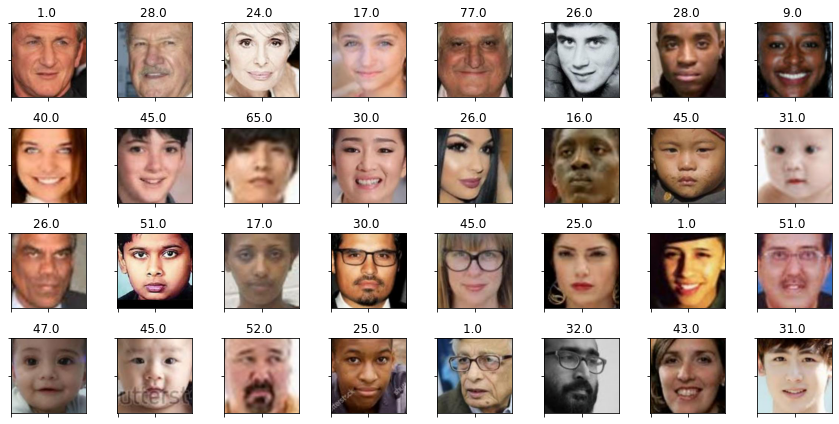

In [ ]:
x1, y1 = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} '  for l in y]
display_batch(x1, titles, ROWS, COLS)

## 3. Modelo


### Bloques

Para este trabajo se nos pide cambiar el bloque resnet por un bloque ConvNext. Recordando como es un bloque Resnet para después transformarlo.

In [ ]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        out_channels1, out_channels2 = out_channels

        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
            # conv1
            # [N, I, H, W] => [N, O1, H, W
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels1, 
                      kernel_size=3, padding=1),
            # [N, O1, H, W]
            nn.BatchNorm2d(out_channels1),
            # [N, O1, H, W]
            nn.ReLU(),
            
            # conv2
            # [N, O1, H, W] => [N, O2, H, W]
            nn.Conv2d(in_channels=out_channels1, 
                      out_channels=out_channels2,
                      kernel_size=3, padding=1),
            # [N, O2, H, W]
            nn.BatchNorm2d(out_channels2),
            # [N, O2, H, W]
            nn.ReLU(),
        )

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, O2, H, W]
        x = x1 + x
        return x

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels):
        super(ConvBlock, self).__init__()
        #out_channels1, out_channels2 = out_channels
        out_channels= in_channels
        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
          nn.Conv2d(
                in_channels, in_channels, kernel_size=7, padding=3, bias=False, groups=in_channels
            ),
            nn.GroupNorm(num_groups=1, num_channels=in_channels),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
          )

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, O2, H, W]
        x = x1 + x
        return x

In [ ]:
modelblock = ConvBlock(3)
summary(modelblock, (3, 200, 200), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 200, 200]         --
|    └─Conv2d: 2-1                       [-1, 3, 200, 200]         147
|    └─GroupNorm: 2-2                    [-1, 3, 200, 200]         6
|    └─Conv2d: 2-3                       [-1, 3, 200, 200]         12
|    └─GELU: 2-4                         [-1, 3, 200, 200]         --
|    └─Conv2d: 2-5                       [-1, 3, 200, 200]         12
Total params: 177
Trainable params: 177
Non-trainable params: 0
Total mult-adds (M): 6.60
Input size (MB): 0.46
Forward/backward pass size (MB): 3.66
Params size (MB): 0.00
Estimated Total Size (MB): 4.12

### Definamos la arquitectura
Usamos el código visto en clase solo cambiando el bloque por el que creamos y el tamaño de la imagen.

In [ ]:
class MicroResNet(nn.Module):

    def __init__(self):
        super(MicroResNet, self).__init__()
        self.num_feats = 3 * 200 * 200

        self.cnn = nn.Sequential(
           
            ConvBlock(in_channels=3),
            # [N, 3, 64, 64] => [N, 3, 32, 32]
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # [N, 3, 32, 32] => [N, 3x32x32]
        self.flatten = nn.Flatten()

        # [N, 3x32x32] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 1)

    def forward(self, x):
        # [N, 3, 64, 64] => [N, 3, 32, 32]
        x = self.cnn(x)
        # [N, 3, 32, 32] => [N, 3x32x32]
        x = self.flatten(x)
        # [N, 3x32x32] => [N, 1]
        #x = self.cls(x)
        return x

    def predict(self, x):
        # [N, 3, 64, 64] => [N, 1]
        y_lgts = self.forward(x)
        # [N, 1]
        y_prob = torch.sigmoid(y_lgts)
        return y_prob

In [ ]:
modelo1 = MicroResNet()
summary(modelo1, (3, 200, 200), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 100, 100]         --
|    └─ConvBlock: 2-1                    [-1, 3, 200, 200]         --
|    |    └─Sequential: 3-1              [-1, 3, 200, 200]         177
|    └─MaxPool2d: 2-2                    [-1, 3, 100, 100]         --
├─Flatten: 1-2                           [-1, 30000]               --
Total params: 177
Trainable params: 177
Non-trainable params: 0
Total mult-adds (M): 6.60
Input size (MB): 0.46
Forward/backward pass size (MB): 3.66
Params size (MB): 0.00
Estimated Total Size (MB): 4.12

## 4. Entrenamiento

In [ ]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
def train_epoch(data_loader,model,opt,epoch):
  # para cada lote
  for x, y_true in data_loader:
    x = x.to(device)
    y_true = y_true.to(device)
    # inferencia
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y_true)
    # backprop
    opt.zero_grad() # vaciamos los gradientes
    loss.backward() # retropropagamos
    opt.step() # actualizamos parámetros

def eval_epoch(data_loader, model, epoch):
  # Para la evaluación evitamos que se regsitren las operaciones
  with torch.no_grad():
    
    losses = []
    
    for x, y_true in data_loader:
      x = x.to(device)
      y_true = y_true.to(device)
      y_hat = model(x) # Evaluamos
      loss_b = F.mse_loss(y_hat, y_true) # Calculamos la pérdida
      losses.append(loss_b.item())
    
    loss = np.mean(losses)
    return loss

def train(model, train_dl, test_dl,epochs=10,lr=1e-3,opt='Adam',
          transfer_learning = False,full_train=False,
          L2lambda=0,progress=True):
  
  model = model.to(device)
  loss_hist = []

  # optimizadores
  if opt == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=L2lambda)
  if opt == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=L2lambda)
  if opt == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=L2lambda)

  # Congelamos loss parámetros
  if transfer_learning:
    freeze = not full_train # si no se quiere reentrenar toda la red, se congelan los parametros
    model.freeze_features(freeze)

  # Para imprimir el progreso
  range_progress = trange(epochs)  if progress else range(epochs)

  model.eval()

  # ciclo de entrenamiento
  for epoch in range_progress:
    # Entrenamiento
    model.train()
    train_epoch(train_dl,model,optimizer,epoch)

    # Evaluación
    model.eval()
    train_loss = eval_epoch(train_dl, model, epoch)
    test_loss = eval_epoch(test_dl, model, epoch)
  
    loss_hist.append([train_loss,test_loss])

    if progress:
      print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}]')
      
  return loss_hist

In [ ]:
loss1= train(modelo1, trn_dl, tst_dl,epochs=10,lr=1e-4,opt='Adam',
          transfer_learning = False,progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 30000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([22, 30000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 30000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([22, 1])) that is different 

E00 loss=[1469.76,1466.63]
E01 loss=[1438.45,1445.28]
E02 loss=[1386.13,1389.71]
E03 loss=[1320.94,1321.16]
E04 loss=[1243.81,1239.43]
E05 loss=[1157.77,1160.22]
E06 loss=[1065.80,1069.43]
E07 loss=[972.41,972.27]
E08 loss=[877.78,875.37]
E09 loss=[788.65,786.21]


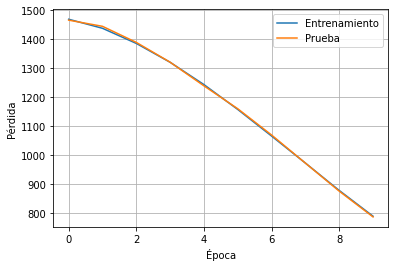

In [ ]:
display_losses(loss1)

### Transferencia de conocimiento
Ahora vamos a usar transferencia de conocimiento para entrenar sólo la última capa y después todo el modelo. Al ser una arquitectura ResNet a pesar de cambiar los bloques creo que es adecuado usar ResNet entrenada misma que brinda PyTorch.


In [ ]:
tvm.resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class TransferModel(nn.Module):
  def __init__(self, pretrained):
    super(TransferModel, self).__init__()

    # carga del modelo
    self.cnn = tvm.resnet50(pretrained=pretrained)
    # reemplazar la FC al ponerle la identidad (puente)
    self.cnn.fc = nn.Identity()

    # numero de inputs de la FC
    in_features = 2048 
    # agregar capa de regresion
    #self.reg = nn.Linear(in_features,1)
    self.reg = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features,1)
    )
  
  def forward(self, x):
    x = self.cnn(x)
    x = self.reg(x)
    return x

  # metodo para congelar los parametros de la CNN
  def freeze_features(self,freeze=True):
    requires_grad = not freeze
    for param in self.cnn.parameters():
      param.requires_grad = requires_grad



In [ ]:
# instancia del modelo
modelo2 = TransferModel(pretrained=True)
# congelar parametros de la CNN
modelo2.freeze_features()
# modelo en modo de evaluacion
_ = modelo2.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
summary(modelo2, (3, 200, 200), device='cpu', verbose = 0)

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 2048]                --
|    └─Conv2d: 2-1                       [-1, 64, 100, 100]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 100, 100]        (128)
|    └─ReLU: 2-3                         [-1, 64, 100, 100]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 50, 50]          --
|    └─Sequential: 2-5                   [-1, 256, 50, 50]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 50, 50]         (75,008)
|    |    └─Bottleneck: 3-2              [-1, 256, 50, 50]         (70,400)
|    |    └─Bottleneck: 3-3              [-1, 256, 50, 50]         (70,400)
|    └─Sequential: 2-6                   [-1, 512, 25, 25]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 25, 25]         (379,392)
|    |    └─Bottleneck: 3-5              [-1, 512, 25, 25]         (280,064)
|    |    └─Bottleneck: 3-6              [-1,

In [ ]:
loss2= train(modelo2, trn_dl, tst_dl, epochs=10, lr=1e-4, opt='Adam',
          transfer_learning = True, full_train=False, progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Problema de tiempo al seguir usando el CPU decidí mejor cambiar el modelo entrenado por uno más pequeño. De hecho la diferencia se ve en el numero de in_features que recibe el modelo.

In [ ]:
class TransferModel1(nn.Module):
  def __init__(self, pretrained):
    super(TransferModel1, self).__init__()

    # carga del modelo
    self.cnn = tvm.squeezenet1_0(pretrained=pretrained)
    # reemplazar la FC al ponerle la identidad (puente)
    self.cnn.fc = nn.Identity()

    # numero de inputs de la FC
    in_features = 1000
    # agregar capa de regresion
    #self.reg = nn.Linear(in_features,1)
    self.reg = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features,1)
    )
  
  def forward(self, x):
    x = self.cnn(x)
    x = self.reg(x)
    return x

  # metodo para congelar los parametros de la CNN
  def freeze_features(self,freeze=True):
    requires_grad = not freeze
    for param in self.cnn.parameters():
      param.requires_grad = requires_grad


In [ ]:
# instancia del modelo
modelo2 = TransferModel1(pretrained=True)
# congelar parametros de la CNN
modelo2.freeze_features()
# modelo en modo de evaluacion
_ = modelo2.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

In [ ]:
summary(modelo2, (3, 200, 200), device='cpu', verbose = 0)

Layer (type:depth-idx)                   Output Shape              Param #
├─SqueezeNet: 1-1                        [-1, 1000]                --
|    └─Sequential: 2-1                   [-1, 512, 12, 12]         --
|    |    └─Conv2d: 3-1                  [-1, 96, 97, 97]          (14,208)
|    |    └─ReLU: 3-2                    [-1, 96, 97, 97]          --
|    |    └─MaxPool2d: 3-3               [-1, 96, 48, 48]          --
|    |    └─Fire: 3-4                    [-1, 128, 48, 48]         (11,920)
|    |    └─Fire: 3-5                    [-1, 128, 48, 48]         (12,432)
|    |    └─Fire: 3-6                    [-1, 256, 48, 48]         (45,344)
|    |    └─MaxPool2d: 3-7               [-1, 256, 24, 24]         --
|    |    └─Fire: 3-8                    [-1, 256, 24, 24]         (49,440)
|    |    └─Fire: 3-9                    [-1, 384, 24, 24]         (104,880)
|    |    └─Fire: 3-10                   [-1, 384, 24, 24]         (111,024)
|    |    └─Fire: 3-11                   

In [ ]:
loss2= train(modelo2, trn_dl, tst_dl, epochs=10, lr=1e-4, opt='Adam',
          transfer_learning = True, full_train=False, progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[1350.29,1331.78]
E01 loss=[791.40,765.40]
E02 loss=[333.35,313.61]
E03 loss=[225.84,210.10]
E04 loss=[211.78,201.43]
E05 loss=[200.62,189.29]
E06 loss=[197.32,186.33]
E07 loss=[192.65,182.73]
E08 loss=[189.97,180.38]
E09 loss=[187.06,179.20]


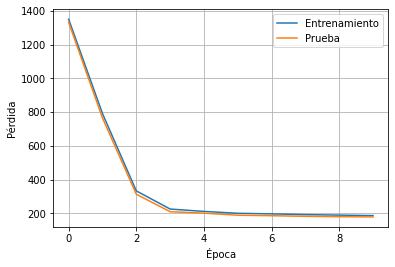

In [ ]:
display_losses(loss2)

In [ ]:
loss3= train(modelo2, trn_dl, tst_dl, epochs=10, lr=1e-4, opt='Adam',
          transfer_learning = True, full_train=True, progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[133.83,131.33]
E01 loss=[ 98.56,100.85]
E02 loss=[ 84.20, 88.27]


In [ ]:
display_losses(loss3)

## 5. Resultados y Conclusiones
Primeramente es importante mencionar el tiempo que tarda para el entrenamiento, por lo que es escencial ya utilizar la GPU en estos procesos. Al no tenerla se me dificultó demasiado el entrenamiento en cuanto al tiempo. Sin embargo, la ventaja respecto a usar un preentrenamiento es bastante como se muestran en las gráficas. Donde en la primera época a la segunda la pérdida disminuyó casi a la mitad, evidentemente si se cuentan con los recursos es ideal utilizar transferencia de aprendizaje.